In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import cv2 
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, LeakyReLU, Activation, UpSampling2D, Concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

Using TensorFlow backend.


# Load CIFAR10 Dataset

First of all, we load CIFAR10 which is part of the Keras Datasets.</br>
We set noise size to 100.

In [ ]:
noise_size = 100
num_classes = 10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


# Data Preprocessing

For data preprocessing phase, we normalize data for better results and faster training. Then we convert labels from integers to one hot labels.

In [ ]:
# Normalize data
x_train = (x_train - 127.5) / 127.5
print ("x_train shape", x_train.shape)

x_train shape (50000, 32, 32, 3)


In [ ]:
def encode_one_hot(labels):
  out = np.zeros((len(labels), num_classes))
  idx = np.arange(len(labels))
  out[idx, labels] = 1
  return out

y_train = encode_one_hot(y_train[:,0])

# Generator

The generator consists of one dense layer, four conv2d layer and two conv2d transpose layer with LeakyReLU and the last layer is con2d with tanh activation function.

In [ ]:
def get_generator(input, condition):
  
  merged_input = Concatenate()([input, condition])  
  
  x = Dense(128 * 8 * 8, activation='relu')(merged_input)    
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Reshape((8, 8, 128))(x)
  
  x = Conv2D(128, kernel_size=4, strides=1,padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)    
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=5, strides=1,padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)    
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=5, strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=5, strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
                      
  x = Conv2D(3, kernel_size=5, strides=1, padding="same")(x)
  out = Activation("tanh")(x)

  gen = Model(inputs=[input, condition], outputs=out)
  gen.summary()
  
  return gen, out

# Discriminator

Then we define the Discriminator part.</br>
The discriminator consists of all convoloutional layers with LeakyReLU with 0.1 parameter with stride 2 and Batch Normalization on every layer and the activation function of the last layer is sigmoid.

In [ ]:
def get_discriminator(input, condition):
  
  x = Conv2D(128, kernel_size=3, strides=1, padding='same')(input)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.9)(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Flatten()(x)
  
  merged = Concatenate()([x, condition])
  x = Dense(512, activation='relu')(merged)
  out = Dense(1, activation='sigmoid')(x)
  
  disc = Model(inputs=[input, condition], outputs=out)
  disc.summary()
  
  return disc, out

# CGAN

First we compile discriminator with binary cross entropy and Adam optimizer.

In [ ]:
img_input = Input(shape=(32,32,3))
disc_condition = Input(shape=(num_classes,))
discriminator, disc_out = get_discriminator(img_input, disc_condition)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 128)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Then we compile generator using binary cross entropy and Adam optimizer.

In [ ]:
noise_input = Input(shape=(noise_size,))
gen_condition = Input(shape=(num_classes,))
generator, gen_out = get_generator(noise_input, gen_condition)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8192)         909312      concatenate_2[0][0]        

Finally we construct the whole CGAN which consists of the generator and the discriminator. Then we compile CGAN using binary cross entropy and Adam optimizer.

In [ ]:
gan_input = Input(shape=(noise_size,))
x = generator([gan_input, gen_condition])
gan_out = discriminator([x, disc_condition])

cgan = Model(inputs=[gan_input, gen_condition, disc_condition], output=gan_out)
cgan.summary()

cgan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 3)    2970755     input_5[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  """


# Train Model

Number of Epochs is 70.</br>
Batch size is 32.

In [ ]:
batch_size = 32
num_epochs = 70

class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Now we define a some helper functions: </br>
Gen_noise function generates a normal noise. </br>
Gen_label function generates a random one hot label. </br>
Show_samples function plots a generated instance of each class. </br>
Plot10x10res function plots a 10x10 grid that each row includes generated instances of one of the classes.

In [ ]:
def gen_noise(batch_size, noise_dim=100):
   x = np.random.normal(0, 1.0, (batch_size, noise_dim))
   return x

def gen_label(num):
  y = np.random.choice(num_classes, num)
  y = encode_one_hot(y)
  return y

def show_samples(e):
  fig, axs = plt.subplots(2, 5, figsize=(15,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.3)
  for i in range(10):
    label = encode_one_hot([i])
    noise = gen_noise(1)
    gen_img = generator.predict([noise, label])
    img = image.array_to_img(gen_img[0], scale=True)
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_labels[i])
  plt.show()
  name = 'pic' + str(e) + '.png'
  fig.savefig('gdrive/My Drive/MiniProj3/Result3/Run4/'+name)

def plot10x10res(gen, e):
  fig = plt.figure(figsize=(15, 15))
  grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.01,)

  for i in range(100):
    l = i // 10
    label = encode_one_hot([l])
    noise = gen_noise(1)
    gen_img = gen.predict([noise, label])
    pic = image.array_to_img(gen_img[0], scale=True)

    grid[i].imshow(pic)
  name = 'pic_final'+ str(e) +'.png'
  fig.savefig('gdrive/My Drive/MiniProj3/Result3/Run4/'+name)

For each epoch, at first we train discriminator with real and fake samples and then train the GAN while freezing the weights of discriminator part.

In [ ]:
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(num_epochs):  
  for i in range(len(x_train) // batch_size):

    # Train Discriminator weights
    discriminator.trainable = True

    # Real samples
    images = x_train[i*batch_size : (i+1)*batch_size]
    labels = y_train[i*batch_size : (i+1)*batch_size]
    d_loss_real = discriminator.train_on_batch(x=[images, labels], y=real)

    # Fake Samples
    noise_data = gen_noise(batch_size)
    random_labels = gen_label(batch_size)
    generated_images = generator.predict([noise_data, random_labels])
    d_loss_fake = discriminator.train_on_batch(x=[generated_images, random_labels], y=fake)

    # Discriminator loss  
    d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
    
    # Train Generator weights
    discriminator.trainable = False
    noise_data = gen_noise(batch_size)
    random_labels = gen_label(batch_size)
    g_loss_batch = cgan.train_on_batch(x=[noise_data, random_labels, random_labels], y=real)
    
  d_loss.append(d_loss_batch)
  g_loss.append(g_loss_batch)
  print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, num_epochs, d_loss[-1], g_loss[-1]), 100*' ')

  if (e+1) % 5 == 0:
    show_samples(e)
  if (e+1)%10 == 0:
    plot10x10res(generator, (e+1)//10)

# Loss Figures

Now using the vectors we have saved in the last part, we plot the loss figures.

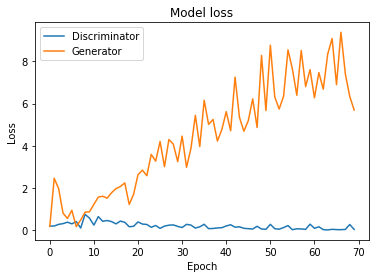

In [ ]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'])
plt.show()

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB
